# Celda 1 — Imports, semillas, hilos, rutas y utilidades

In [13]:
# ==== Imports base ====
import os, time, gc, itertools, json
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# ==== Reproducibilidad ====
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==== Control de hilos (Windows/CPU) para estabilidad ====
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

# ==== Rutas ====
DATA_DIR   = Path("../data/processed/seq")
REPORT_DIR = Path("../reports/models")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# util para tiempo bonito
def mmss(t):
    m = int(t // 60); s = int(t % 60)
    return f"{m:02d}:{s:02d}"


# Celda 2 — Carga de secuencias (de Cuaderno 4)

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

def _load_idx_any(path_npy: Path, path_csv: Path) -> pd.DatetimeIndex:
    """Carga índice de fechas desde .npy o .csv y lo devuelve como DatetimeIndex."""
    if path_npy.exists():
        arr = np.load(path_npy)  # puede venir como str o datetime64
        return pd.DatetimeIndex(arr)
    if path_csv.exists():
        df = pd.read_csv(path_csv)
        # intenta columnas típicas de fecha
        for col in ["Date", "date", "fecha", "idx", "index"]:
            if col in df.columns:
                return pd.DatetimeIndex(pd.to_datetime(df[col], utc=False))
        # si solo hay 1 columna, usa esa
        if df.shape[1] == 1:
            return pd.DatetimeIndex(pd.to_datetime(df.iloc[:, 0], utc=False))
        raise ValueError(f"No se encontró columna de fecha en {path_csv}")
    raise FileNotFoundError(f"Falta índice: {path_npy.name} / {path_csv.name}")

def load_seq(ticker: str, window: int):
    base = DATA_DIR / ticker / f"w{window}"

    # Arrays (estos sí son .npy)
    Xtr = np.load(base/"X_train.npy"); ytr = np.load(base/"y_train.npy")
    Xva = np.load(base/"X_val.npy");   yva = np.load(base/"y_val.npy")
    Xte = np.load(base/"X_test.npy");  yte = np.load(base/"y_test.npy")

    # Índices: intenta .npy y, si no, .csv
    idx_tr = _load_idx_any(base/"idx_train.npy", base/"idx_train.csv")
    idx_va = _load_idx_any(base/"idx_val.npy",   base/"idx_val.csv")
    idx_te = _load_idx_any(base/"idx_test.npy",  base/"idx_test.csv")

    # Meta
    meta_path = base/"meta.json"
    meta = json.load(open(meta_path, "r")) if meta_path.exists() else {
        "ticker": ticker, "window": window, "n_features": Xtr.shape[-1]
    }

    return (Xtr,ytr),(Xva,yva),(Xte,yte),meta



# Celda 3 — Baseline de persistencia (diagnóstico)

In [15]:
def naive_persistence(X3: np.ndarray) -> np.ndarray:
    """Devuelve el último Close de la ventana (asumimos Close como 1ª feature)."""
    return X3[:, -1, 0]

for tkr in ["BBVA","SAN"]:
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, 20)
    yhat_naive = naive_persistence(Xte)
    mse_naive = np.mean((yhat_naive - yte)**2)
    print(f"{tkr} · Naive (persistencia) · MSE test = {mse_naive:.6f}")


BBVA · Naive (persistencia) · MSE test = 0.012875
SAN · Naive (persistencia) · MSE test = 0.018460


# Celda 4 — Constructor de modelos (robusto y sin warning)

In [16]:
def build_model(model_type: str, units: int, n_features: int, window_size: int, lr: float) -> keras.Model:
    inp = keras.Input(shape=(window_size, n_features), name="seq")
    if model_type == "SimpleRNN":
        x = layers.SimpleRNN(units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1,
                             kernel_regularizer=regularizers.l2(1e-5))(inp)
        x = layers.SimpleRNN(units, dropout=0.1, recurrent_dropout=0.1)(x)
    elif model_type == "LSTM":
        x = layers.LSTM(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inp)
        x = layers.LSTM(units, dropout=0.2, recurrent_dropout=0.2)(x)
    elif model_type == "GRU":
        x = layers.GRU(units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inp)
        x = layers.GRU(units, dropout=0.2, recurrent_dropout=0.2)(x)
    else:
        raise ValueError("model_type debe ser 'SimpleRNN', 'LSTM' o 'GRU'")
    out = layers.Dense(1, name="y")(x)

    model = keras.Model(inp, out, name=f"{model_type}_u{units}_w{window_size}")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mse"])
    return model


# Celda 5 — Callbacks de progreso y límite por combo

In [17]:
MAX_EPOCHS = 80     # puedes ajustar
PATIENCE   = 3       # EarlyStopping
MAX_SECS   = 30*60   # ⏱️ límite por combo (None para sin límite)

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.t0 = time.time()
    def on_epoch_begin(self, epoch, logs=None):
        print(f"    · epoch {epoch+1}/{self.params.get('epochs', '?')} ...", flush=True)
    def on_train_end(self, logs=None):
        print(f"    · done in {mmss(time.time()-self.t0)}", flush=True)

class StopAfterSeconds(keras.callbacks.Callback):
    def __init__(self, seconds=None):
        super().__init__(); self.seconds = seconds
    def on_train_begin(self, logs=None):
        self.t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        if self.seconds is not None and (time.time()-self.t0) > self.seconds:
            print("    ⏱️  Paro por tiempo máximo de combo", flush=True)
            self.model.stop_training = True


# Celda 6 — Entrenar con logs + evaluar (sustituye a fit_and_eval)

In [18]:
def fit_and_eval_with_logs(model_type, tkr, W, units, batch, lr, epochs=MAX_EPOCHS):
    # Datos
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, W)
    n_features = meta["n_features"]

    # Modelo
    model = build_model(model_type, units, n_features, W, lr)

    # Datasets tf.data (más estables en memoria)
    ds_tr = tf.data.Dataset.from_tensor_slices((Xtr, ytr)).batch(batch).cache().prefetch(tf.data.AUTOTUNE)
    ds_va = tf.data.Dataset.from_tensor_slices((Xva, yva)).batch(batch)
    ds_te = tf.data.Dataset.from_tensor_slices((Xte, yte)).batch(batch)

    # Callbacks
    cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
           TimeHistory(),
           StopAfterSeconds(MAX_SECS)]

    # Entrenamiento
    h = model.fit(ds_tr, validation_data=ds_va, epochs=epochs, verbose=0, callbacks=cbs)

    # Evaluación
    y_pred_va = model.predict(ds_va, verbose=0).ravel()
    y_pred_te = model.predict(ds_te, verbose=0).ravel()
    val_mse = float(np.mean((y_pred_va - yva)**2))
    test_mse = float(np.mean((y_pred_te - yte)**2))

    # Limpieza memoria
    keras.backend.clear_session(); del model
    gc.collect()

    return {"val_mse": val_mse, "test_mse": test_mse}


# Celda 7 — Configuración del grid (con recorte SAN·LSTM)

In [19]:
TICKERS = ["BBVA", "SAN"]
MODELS  = ["SimpleRNN", "LSTM", "GRU"]

GRID = {
    "window": [10,20,30],
    "units":  [32,64,128],
    "batch":  [32,64],
    "lr":     [1e-3, 5e-4],
}

def grid_for(ticker, model):
    g = {k: v[:] for k, v in GRID.items()}
    # ⚠️ Cuello típico: SAN · LSTM — lo recortamos para no atascar
    if ticker == "SAN" and model == "LSTM":
        g["window"] = [20,30]
        g["units"]  = [64,128]
        g["batch"]  = [32]   # quita 64 para evitar swap
    return g


# Celda 8 — (Opcional) Curvas de pérdida rápidas (5/7/10 epochs)

# Celda 9 — Grid Search con progreso, guardado incremental y reanudación

In [20]:
OUT_DIR = REPORT_DIR
OUT_DIR.mkdir(parents=True, exist_ok=True)

def grid_search_for_model(tkr: str, model_type: str) -> pd.DataFrame:
    partial_csv = OUT_DIR / f"grid_partial_{tkr}_{model_type}.csv"
    rows = []

    # Reanudación si existe parcial
    if partial_csv.exists():
        prev = pd.read_csv(partial_csv)
        rows = prev.to_dict("records")
        print(f"⏭️  Reanudando: {len(rows)} combos ya terminados")

    done = {(r["window"], r["units"], r["batch"], float(r["lr"])) for r in rows}
    g = grid_for(tkr, model_type)
    combos = list(itertools.product(g["window"], g["units"], g["batch"], g["lr"]))
    total = len(combos)

    for i, (W, U, B, LR) in enumerate(combos, start=1):
        if (W,U,B,float(LR)) in done:
            print(f"⏭️  {tkr} · {model_type} · combo {i}/{total} (W={W},U={U},B={B},lr={LR}) ya estaba")
            continue

        print(f"\n▶ {tkr} · {model_type} · combo {i}/{total}  (W={W}, U={U}, B={B}, lr={LR})")
        t0 = time.time()
        try:
            res = fit_and_eval_with_logs(model_type, tkr, W, units=U, batch=B, lr=LR, epochs=MAX_EPOCHS)
            status = "ok"
        except Exception as e:
            print(f"    ⚠️  Error: {type(e).__name__}: {e}")
            res = {"val_mse": np.nan, "test_mse": np.nan}
            status = f"error:{type(e).__name__}"

        dt = time.time() - t0
        print(f"    ↳ val_mse={res['val_mse']:.6f} · test_mse={res['test_mse']:.6f} · {mmss(dt)}")

        rows.append({
            "ticker": tkr, "model": model_type,
            "window": W, "units": U, "batch": B, "lr": LR,
            "val_mse": res["val_mse"], "test_mse": res["test_mse"],
            "secs": round(dt,1), "status": status
        })
        pd.DataFrame(rows).to_csv(partial_csv, index=False)

        time.sleep(0.2)  # respiro
        gc.collect()

    df_rank = pd.DataFrame(rows).sort_values(["val_mse","test_mse"], na_position="last").reset_index(drop=True)
    return df_rank

all_ranks = []
for tkr in TICKERS:
    for m in MODELS:
        print(f"\n==== Grid Search: {tkr} · {m} ====")
        rank_df = grid_search_for_model(tkr, m)
        rank_df.to_csv(OUT_DIR / f"grid_{tkr}_{m}.csv", index=False)
        all_ranks.append(rank_df.assign(order=range(1, len(rank_df)+1)))

grid_all = pd.concat(all_ranks, ignore_index=True)
grid_all.head()



==== Grid Search: BBVA · SimpleRNN ====
⏭️  Reanudando: 5 combos ya terminados
⏭️  BBVA · SimpleRNN · combo 1/36 (W=10,U=32,B=32,lr=0.001) ya estaba
⏭️  BBVA · SimpleRNN · combo 2/36 (W=10,U=32,B=32,lr=0.0005) ya estaba
⏭️  BBVA · SimpleRNN · combo 3/36 (W=10,U=32,B=64,lr=0.001) ya estaba
⏭️  BBVA · SimpleRNN · combo 4/36 (W=10,U=32,B=64,lr=0.0005) ya estaba
⏭️  BBVA · SimpleRNN · combo 5/36 (W=10,U=64,B=32,lr=0.001) ya estaba

▶ BBVA · SimpleRNN · combo 6/36  (W=10, U=64, B=32, lr=0.0005)
    · epoch 1/80 ...
    · epoch 2/80 ...
    · epoch 3/80 ...
    · epoch 4/80 ...
    · epoch 5/80 ...
    · epoch 6/80 ...
    · epoch 7/80 ...
    · epoch 8/80 ...
    · epoch 9/80 ...
    · done in 00:09
    ↳ val_mse=0.004908 · test_mse=0.030857 · 00:10

▶ BBVA · SimpleRNN · combo 7/36  (W=10, U=64, B=64, lr=0.001)
    · epoch 1/80 ...
    · epoch 2/80 ...
    · epoch 3/80 ...
    · epoch 4/80 ...
    · epoch 5/80 ...
    · epoch 6/80 ...
    · epoch 7/80 ...
    · epoch 8/80 ...
    · epoch 9

,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000247,0.010429,14.2,ok,1
1,BBVA,SimpleRNN,20,64,32,0.0010,0.000294,0.014740,21.2,ok,2
2,BBVA,SimpleRNN,20,64,64,0.0010,0.000302,0.003813,14.1,ok,3
3,BBVA,SimpleRNN,30,64,32,0.0005,0.000321,0.010423,26.9,ok,4
4,BBVA,SimpleRNN,20,64,64,0.0005,0.000377,0.007117,15.6,ok,5


# Celda 10 — Top-10 por ticker/modelo y resumen “mejor de cada uno”

In [21]:
# Top-10 por grupo
tops = []
for tkr in TICKERS:
    for m in MODELS:
        dfm = grid_all[(grid_all["ticker"]==tkr) & (grid_all["model"]==m)].sort_values(["val_mse","test_mse"]).head(10)
        dfm.to_csv(OUT_DIR / f"top10_{tkr}_{m}.csv", index=False)
        print(f"\n=== {tkr} · {m} — Top-10 (por val_mse) ===")
        display(dfm)
        tops.append(dfm.assign(kind=f"{tkr}_{m}"))

top_all = pd.concat(tops, ignore_index=True)
top_all.to_csv(OUT_DIR / "top10_all.csv", index=False)

# Mejor de cada grupo
best_rows = []
for t in TICKERS:
    for m in MODELS:
        best_rows.append(grid_all[(grid_all.ticker==t)&(grid_all.model==m)].sort_values(["val_mse","test_mse"]).iloc[0])
best_table = pd.DataFrame(best_rows).reset_index(drop=True)
best_table.to_csv(OUT_DIR / "best_models_summary.csv", index=False)
display(best_table)
print("✅ Guardado resumen:", OUT_DIR / "best_models_summary.csv")



=== BBVA · SimpleRNN — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000247,0.010429,14.2,ok,1
1,BBVA,SimpleRNN,20,64,32,0.0010,0.000294,0.014740,21.2,ok,2
2,BBVA,SimpleRNN,20,64,64,0.0010,0.000302,0.003813,14.1,ok,3
3,BBVA,SimpleRNN,30,64,32,0.0005,0.000321,0.010423,26.9,ok,4
4,BBVA,SimpleRNN,20,64,64,0.0005,0.000377,0.007117,15.6,ok,5
5,BBVA,SimpleRNN,30,64,32,0.0010,0.000412,0.014149,29.3,ok,6
6,BBVA,SimpleRNN,30,32,64,0.0010,0.000452,0.001529,18.4,ok,7
7,BBVA,SimpleRNN,20,32,32,0.0005,0.000542,0.006686,23.6,ok,8
8,BBVA,SimpleRNN,20,128,64,0.0010,0.000568,0.009461,15.7,ok,9
9,BBVA,SimpleRNN,10,64,64,0.0005,0.000724,0.002620,8.8,ok,10



=== BBVA · LSTM — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
36,BBVA,LSTM,10,128,32,0.0005,0.000278,0.000864,NaN,NaN,1
37,BBVA,LSTM,30,128,32,0.0010,0.000287,0.000829,NaN,NaN,2
38,BBVA,LSTM,20,64,64,0.0005,0.000295,0.000814,NaN,NaN,3
39,BBVA,LSTM,30,128,64,0.0005,0.000300,0.000892,NaN,NaN,4
40,BBVA,LSTM,20,32,64,0.0010,0.000310,0.001142,NaN,NaN,5
41,BBVA,LSTM,10,128,64,0.0010,0.000322,0.000839,NaN,NaN,6
42,BBVA,LSTM,20,32,32,0.0010,0.000324,0.001180,NaN,NaN,7
43,BBVA,LSTM,20,128,32,0.0005,0.000332,0.000817,NaN,NaN,8
44,BBVA,LSTM,20,128,64,0.0005,0.000335,0.000847,NaN,NaN,9
45,BBVA,LSTM,10,64,32,0.0010,0.000335,0.000751,NaN,NaN,10



=== BBVA · GRU — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
72,BBVA,GRU,10,128,32,0.0005,0.000224,0.000654,NaN,NaN,1
73,BBVA,GRU,20,128,64,0.0005,0.000254,0.000641,NaN,NaN,2
74,BBVA,GRU,10,64,32,0.0005,0.000259,0.000927,NaN,NaN,3
75,BBVA,GRU,20,64,64,0.0010,0.000290,0.000658,NaN,NaN,4
76,BBVA,GRU,30,32,64,0.0005,0.000291,0.001006,NaN,NaN,5
77,BBVA,GRU,30,64,64,0.0010,0.000293,0.001049,NaN,NaN,6
78,BBVA,GRU,20,32,64,0.0010,0.000298,0.000795,NaN,NaN,7
79,BBVA,GRU,10,32,32,0.0005,0.000310,0.001078,NaN,NaN,8
80,BBVA,GRU,10,64,64,0.0005,0.000317,0.000986,NaN,NaN,9
81,BBVA,GRU,10,64,32,0.0010,0.000319,0.000920,NaN,NaN,10



=== SAN · SimpleRNN — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
108,SAN,SimpleRNN,20,32,64,0.0010,0.000430,0.000614,NaN,NaN,1
109,SAN,SimpleRNN,20,128,64,0.0010,0.000482,0.000566,NaN,NaN,2
110,SAN,SimpleRNN,20,64,32,0.0005,0.000485,0.000517,NaN,NaN,3
111,SAN,SimpleRNN,30,64,64,0.0010,0.000486,0.000493,NaN,NaN,4
112,SAN,SimpleRNN,20,64,32,0.0010,0.000509,0.002873,NaN,NaN,5
113,SAN,SimpleRNN,30,128,32,0.0005,0.000514,0.000770,NaN,NaN,6
114,SAN,SimpleRNN,20,128,32,0.0005,0.000521,0.001730,NaN,NaN,7
115,SAN,SimpleRNN,10,64,32,0.0005,0.000533,0.001203,NaN,NaN,8
116,SAN,SimpleRNN,10,128,64,0.0005,0.000548,0.001018,NaN,NaN,9
117,SAN,SimpleRNN,30,64,64,0.0005,0.000549,0.000662,NaN,NaN,10



=== SAN · LSTM — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
144,SAN,LSTM,10,64,32,0.0010,0.000353,0.000527,NaN,NaN,1
145,SAN,LSTM,30,64,32,0.0010,0.000372,0.002414,30.6,ok,2
146,SAN,LSTM,30,128,32,0.0005,0.000388,0.001996,40.3,ok,3
147,SAN,LSTM,20,128,32,0.0005,0.000413,0.001367,34.5,ok,4
148,SAN,LSTM,20,128,32,0.0010,0.000441,0.003141,35.3,ok,5
149,SAN,LSTM,10,32,64,0.0010,0.000449,0.000424,NaN,NaN,6
150,SAN,LSTM,10,32,64,0.0005,0.000455,0.000381,NaN,NaN,7
151,SAN,LSTM,20,64,32,0.0010,0.000467,0.002486,21.1,ok,8
152,SAN,LSTM,30,128,32,0.0010,0.000477,0.002997,46.6,ok,9
153,SAN,LSTM,10,32,32,0.0005,0.000562,0.000485,NaN,NaN,10



=== SAN · GRU — Top-10 (por val_mse) ===


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
157,SAN,GRU,20,128,64,0.0005,0.000044,0.000057,NaN,NaN,1
158,SAN,GRU,30,128,32,0.0010,0.000044,0.000061,NaN,NaN,2
159,SAN,GRU,10,128,64,0.0010,0.000046,0.000060,NaN,NaN,3
160,SAN,GRU,30,32,32,0.0005,0.000047,0.000059,NaN,NaN,4
161,SAN,GRU,10,32,32,0.0010,0.000049,0.000068,NaN,NaN,5
162,SAN,GRU,20,128,32,0.0005,0.000049,0.000067,NaN,NaN,6
163,SAN,GRU,20,128,64,0.0010,0.000049,0.000062,NaN,NaN,7
164,SAN,GRU,20,128,32,0.0010,0.000051,0.000069,NaN,NaN,8
165,SAN,GRU,20,64,32,0.0005,0.000053,0.000065,NaN,NaN,9
166,SAN,GRU,30,64,32,0.0005,0.000055,0.000071,NaN,NaN,10


,ticker,model,window,units,batch,lr,val_mse,test_mse,secs,status,order
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000247,0.010429,14.2,ok,1
1,BBVA,LSTM,10,128,32,0.0005,0.000278,0.000864,NaN,NaN,1
2,BBVA,GRU,10,128,32,0.0005,0.000224,0.000654,NaN,NaN,1
3,SAN,SimpleRNN,20,32,64,0.0010,0.000430,0.000614,NaN,NaN,1
4,SAN,LSTM,10,64,32,0.0010,0.000353,0.000527,NaN,NaN,1
5,SAN,GRU,20,128,64,0.0005,0.000044,0.000057,NaN,NaN,1


✅ Guardado resumen: ..\reports\models\best_models_summary.csv


# Celda 11 — Real vs Predicho de los mejores (plots)

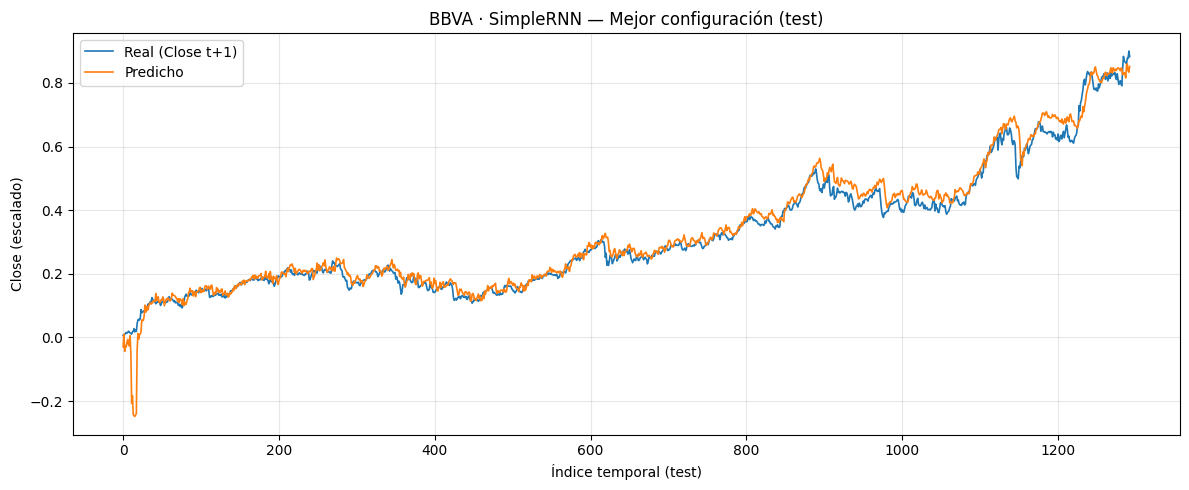

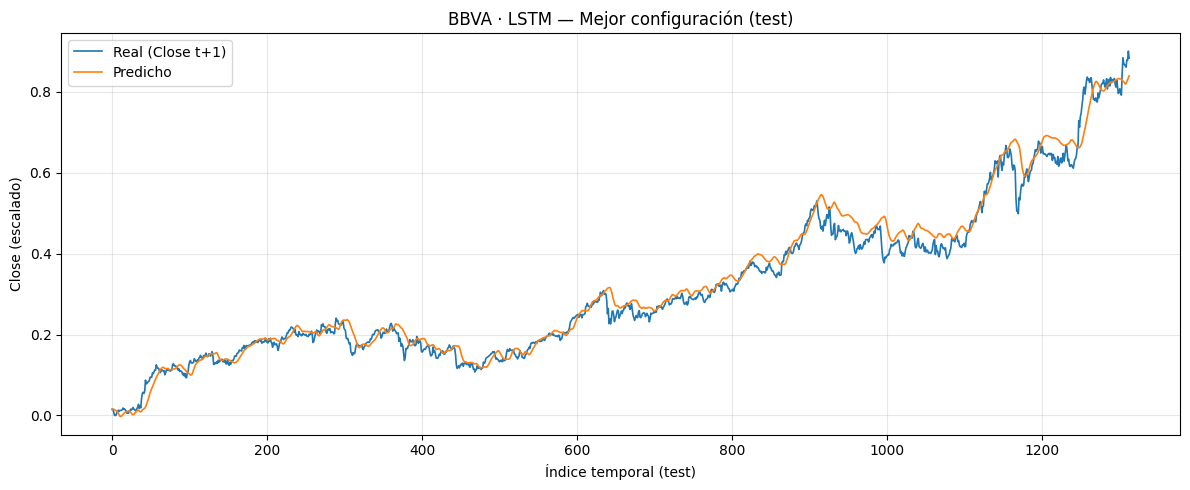

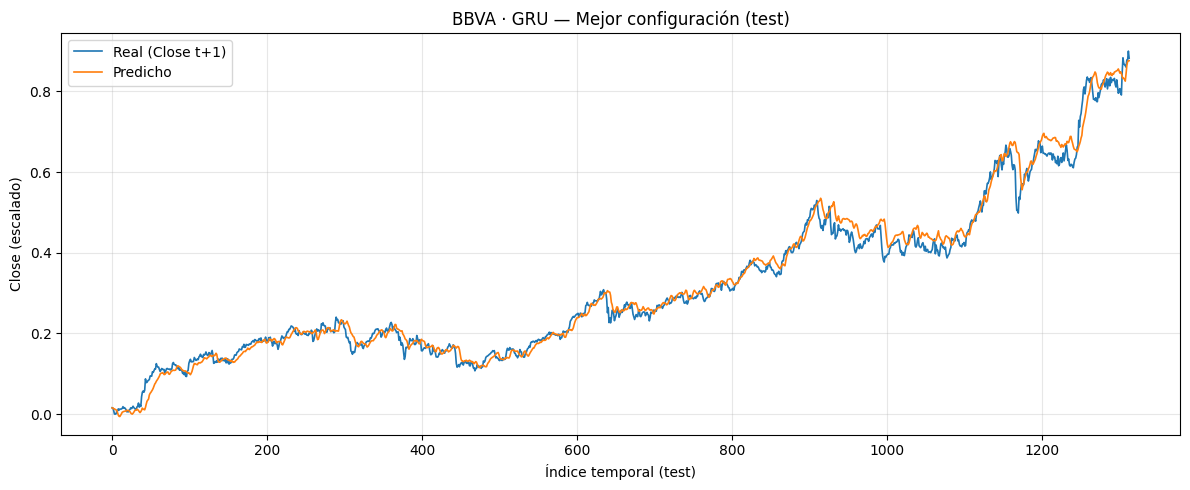

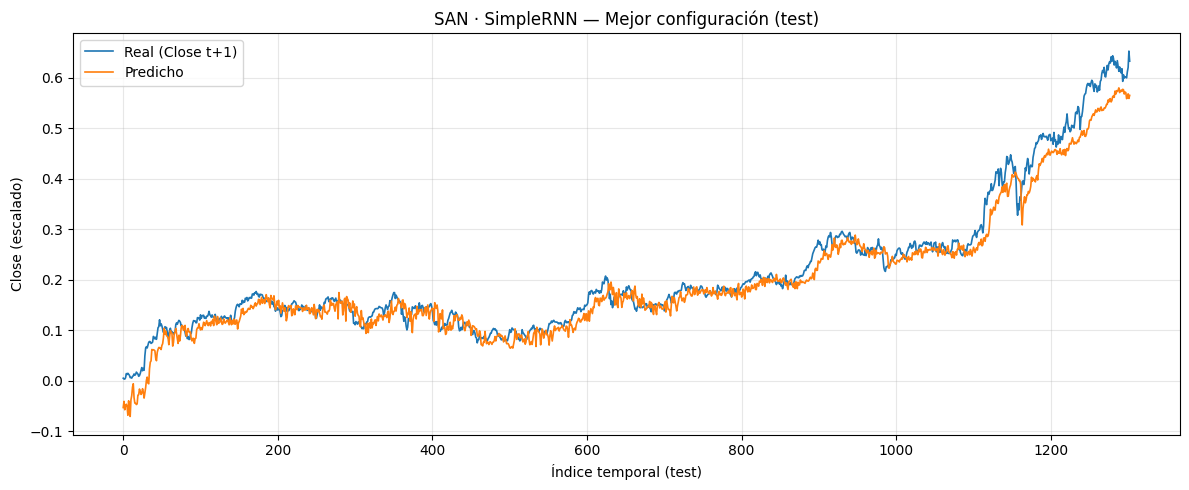

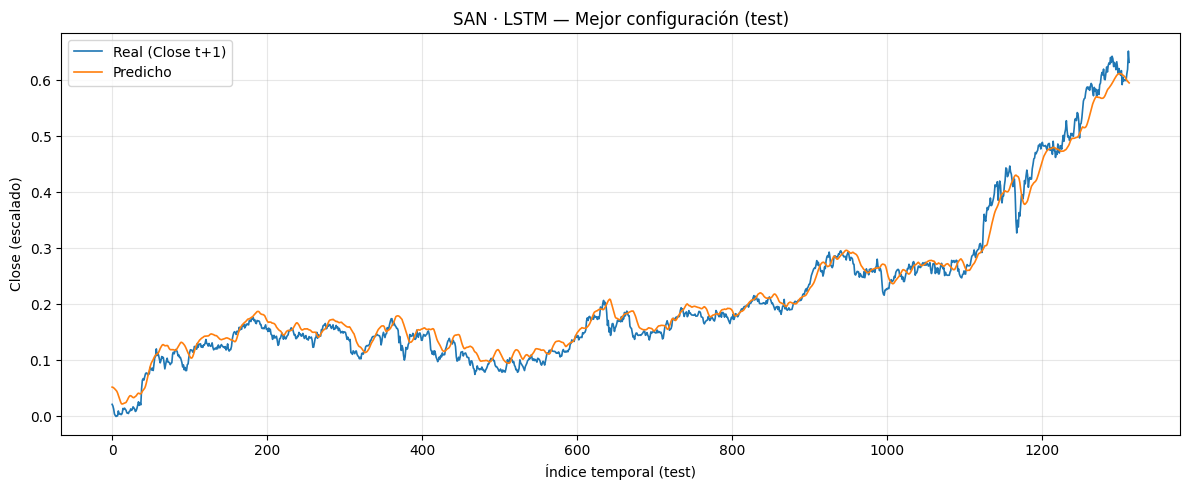

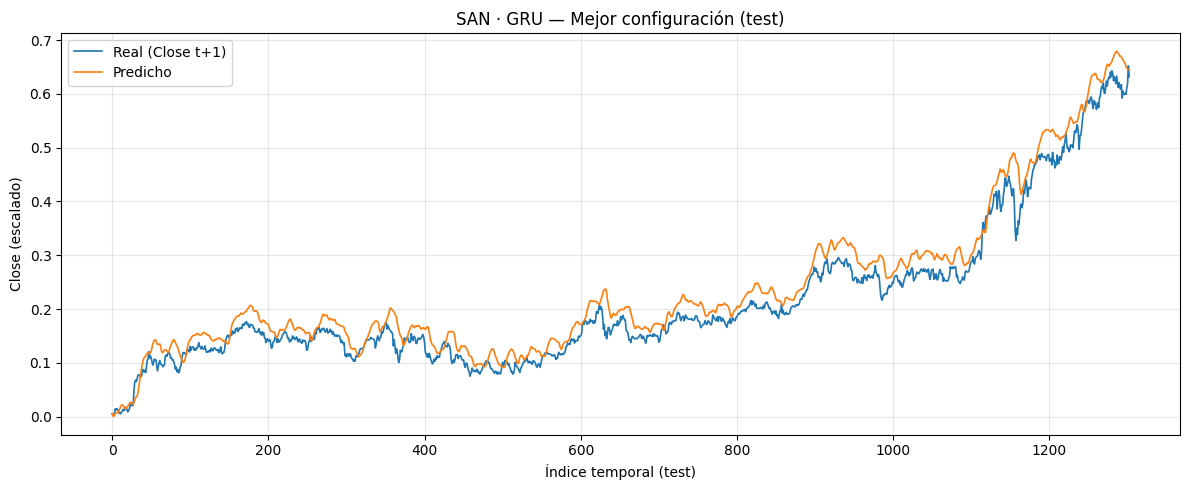

,ticker,model,window,units,batch,lr,val_mse,test_mse
2,BBVA,GRU,10,128,32,0.0005,0.000231,0.000616
1,BBVA,LSTM,10,128,32,0.0005,0.000279,0.000898
0,BBVA,SimpleRNN,30,64,64,0.0010,0.000311,0.001174
4,SAN,LSTM,10,64,32,0.0010,0.000447,0.000442
3,SAN,SimpleRNN,20,32,64,0.0010,0.000431,0.000780
5,SAN,GRU,20,128,64,0.0005,0.000720,0.000968


In [22]:
def best_config(df: pd.DataFrame, tkr: str, m: str):
    sub = df[(df["ticker"]==tkr) & (df["model"]==m)].sort_values(["val_mse","test_mse"]).head(1).iloc[0]
    return dict(W=int(sub["window"]), U=int(sub["units"]), B=int(sub["batch"]), LR=float(sub["lr"]))

def plot_real_pred(y_true, y_pred, title):
    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Real (Close t+1)", linewidth=1.2)
    plt.plot(y_pred, label="Predicho", linewidth=1.2)
    plt.title(title); plt.xlabel("Índice temporal (test)"); plt.ylabel("Close (escalado)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

best_runs = []
for tkr in TICKERS:
    for m in MODELS:
        cfg = best_config(grid_all, tkr, m)
        # Entrenamos SOLO para graficar (pocas épocas por rapidez)
        (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, cfg["W"])
        model = build_model(m, cfg["U"], meta["n_features"], cfg["W"], cfg["LR"])
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=min(20, MAX_EPOCHS), batch_size=cfg["B"], verbose=0, callbacks=[es])
        yhat = model.predict(Xte, verbose=0).ravel()
        val_mse = float(np.mean((model.predict(Xva, verbose=0).ravel() - yva)**2))
        test_mse = float(np.mean((yhat - yte)**2))
        plot_real_pred(yte, yhat, f"{tkr} · {m} — Mejor configuración (test)")
        best_runs.append({
            "ticker": tkr, "model": m, "window": cfg["W"], "units": cfg["U"],
            "batch": cfg["B"], "lr": cfg["LR"], "val_mse": val_mse, "test_mse": test_mse
        })
        keras.backend.clear_session(); del model; gc.collect()

best_table = pd.DataFrame(best_runs).sort_values(["ticker","test_mse"])
best_table.to_csv(OUT_DIR / "best_models_summary.csv", index=False)
display(best_table)


# Celda 12 — Mejora vs persistencia para los mejores

In [23]:
def mse(a,b): return float(np.mean((a-b)**2))

for row in best_table.itertuples(index=False):
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(row.ticker, int(row.window))
    model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=min(30, MAX_EPOCHS), batch_size=int(row.batch), verbose=0, callbacks=[es])
    yhat = model.predict(Xte, verbose=0).ravel()
    ynaive = naive_persistence(Xte)
    mse_model = mse(yte, yhat)
    mse_naive = mse(yte, ynaive)
    imp = 100*(1 - mse_model/mse_naive)
    print(f"{row.ticker} · {row.model} (W={row.window}, U={row.units}) → MSE={mse_model:.6f} | Naive={mse_naive:.6f} | Mejora={imp:.2f}%")
    keras.backend.clear_session(); del model; gc.collect()


BBVA · GRU (W=10, U=128) → MSE=0.000545 | Naive=0.012939 | Mejora=95.79%
BBVA · LSTM (W=10, U=128) → MSE=0.000907 | Naive=0.012939 | Mejora=92.99%
BBVA · SimpleRNN (W=30, U=64) → MSE=0.000522 | Naive=0.012792 | Mejora=95.92%
SAN · LSTM (W=10, U=64) → MSE=0.000799 | Naive=0.018497 | Mejora=95.68%
SAN · SimpleRNN (W=20, U=32) → MSE=0.003337 | Naive=0.018460 | Mejora=81.93%
SAN · GRU (W=20, U=128) → MSE=0.000838 | Naive=0.018460 | Mejora=95.46%


# Celda 13 — Comparativa MSE (barras)

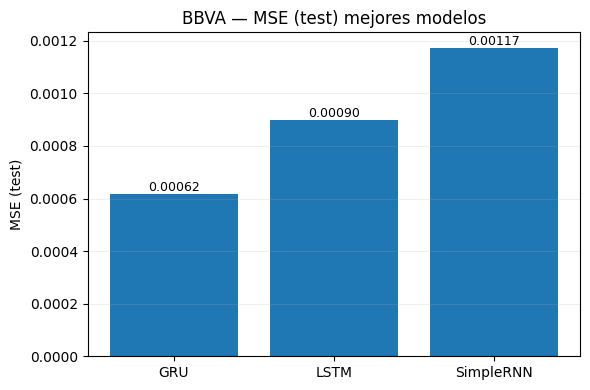

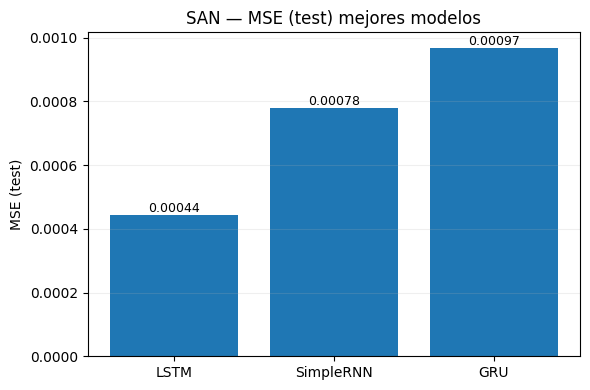

In [24]:
def bar_compare(best_table, ticker):
    sub = best_table[best_table["ticker"]==ticker].sort_values("test_mse")
    plt.figure(figsize=(6,4))
    plt.bar(sub["model"], sub["test_mse"])
    for i,(m,v) in enumerate(zip(sub["model"], sub["test_mse"])):
        plt.text(i, v, f"{v:.5f}", ha="center", va="bottom", fontsize=9)
    plt.title(f"{ticker} — MSE (test) mejores modelos")
    plt.ylabel("MSE (test)"); plt.grid(axis="y", alpha=0.2)
    plt.tight_layout(); plt.show()

for tkr in TICKERS:
    bar_compare(best_table, tkr)


# Celda 14 — Guardar modelos .h5 (para Cuaderno 6)

In [25]:
SAVE_MODELS = True

if SAVE_MODELS:
    for row in best_table.itertuples(index=False):
        (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(row.ticker, int(row.window))
        model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=min(30, MAX_EPOCHS), batch_size=int(row.batch), verbose=0, callbacks=[es])
        path = OUT_DIR / f"{row.ticker}_{row.model}_w{row.window}_u{row.units}_b{row.batch}_lr{row.lr}.h5"
        model.save(path)
        print("💾 Guardado:", path)
        keras.backend.clear_session(); del model; gc.collect()


💾 Guardado: ..\reports\models\BBVA_GRU_w10_u128_b32_lr0.0005.h5


💾 Guardado: ..\reports\models\BBVA_LSTM_w10_u128_b32_lr0.0005.h5


💾 Guardado: ..\reports\models\BBVA_SimpleRNN_w30_u64_b64_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_LSTM_w10_u64_b32_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_SimpleRNN_w20_u32_b64_lr0.001.h5


💾 Guardado: ..\reports\models\SAN_GRU_w20_u128_b64_lr0.0005.h5


In [ ]:
# ==== Inversión del escalado del target (Close) ====
import pandas as pd

def inverse_close_from_train_minmax(y_scaled, tkr: str, W: int):
    """
    Convierte valores escalados (0-1) a euros usando Min/Max del TRAIN.
    Requiere poder leer los índices de TRAIN y el 'Close' original.
    """
    base = DATA_DIR / tkr / f"w{W}"
    idx_tr = pd.to_datetime(pd.read_csv(base/"idx_train.csv")["date"])
    
    # Carga serie original de precios (ajusta la ruta/nombre si el tuyo es otro)
    # Debe contener columnas Close_BBVA / Close_SAN y un índice de fechas.
    prices = pd.read_csv("../data/processed/processed_unscaled.csv", parse_dates=["Date"]).set_index("Date")
    close_ser = prices[f"Close_{tkr}"]
    
    y_min = close_ser.loc[idx_tr].min()
    y_max = close_ser.loc[idx_tr].max()
    return y_scaled * (y_max - y_min) + y_min

def get_true_close_in_euros(tkr: str, W: int):
    """Devuelve y_true del TEST en euros leyendo la serie original por índice."""
    base = DATA_DIR / tkr / f"w{W}"
    idx_te = pd.to_datetime(pd.read_csv(base/"idx_test.csv")["date"])
    prices = pd.read_csv("../data/processed/processed_unscaled.csv", parse_dates=["Date"]).set_index("Date")
    close_ser = prices[f"Close_{tkr}"]
    return close_ser.loc[idx_te].values, idx_te


In [27]:
import matplotlib.pyplot as plt

def plot_best_in_euros(tkr: str, row, epochs=MAX_EPOCHS):
    # Carga secuencias y entrena con la mejor config
    (Xtr,ytr),(Xva,yva),(Xte,yte),meta = load_seq(tkr, int(row.window))
    model = build_model(row.model, int(row.units), meta["n_features"], int(row.window), float(row.lr))
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    model.fit(Xtr, ytr, validation_data=(Xva,yva), epochs=epochs, batch_size=int(row.batch), verbose=0, callbacks=[es])
    y_pred_scaled = model.predict(Xte, verbose=0).ravel()
    
    # Desescalar predicción y obtener verdad-terreno en €
    y_pred_eur, = (inverse_close_from_train_minmax(y_pred_scaled, tkr, int(row.window)),)
    y_true_eur, idx_te = get_true_close_in_euros(tkr, int(row.window))
    
    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(idx_te, y_true_eur, label="Real (€)", linewidth=1.2)
    plt.plot(idx_te, y_pred_eur, label="Predicho (€)", linewidth=1.2)
    plt.title(f"{tkr} · {row.model} — Mejor configuración (euros)")
    plt.xlabel("Fecha"); plt.ylabel("Close (€)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()
    
    # MSE en euros (opcional)
    mse_eur = float(np.mean((y_pred_eur - y_true_eur)**2))
    print(f"MSE en euros ({tkr} · {row.model}): {mse_eur:.6f}")

# Ejemplo: dibuja BBVA y SAN en euros usando tu best_table
for tkr in ["BBVA","SAN"]:
    row = best_table[best_table["ticker"]==tkr].sort_values("test_mse").iloc[0]
    plot_best_in_euros(tkr, row)


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/merged_prices.csv'